### **Installing Required Libraries**

Below command installs the essential libraries that will be used throughout the notebook. Here's a brief explanation of each:



1. **`numpy`**: A fundamental library for numerical computations in Python. It provides support for multi-dimensional arrays and mathematical operations.

2. **`pandas`**: A powerful library for data manipulation and analysis, particularly for handling tabular data in DataFrames.

3. **`tensorflow`**: An open-source deep learning library, used here for building and training neural networks, including transfer learning models.

4. **`seaborn`**: A data visualization library built on top of Matplotlib, offering easy-to-use interfaces for creating attractive visualizations.

5. **`matplotlib`**: A comprehensive library for creating static, animated, and interactive visualizations in Python.

6. **`tqdm`**: A library for creating progress bars, useful for monitoring the progress of loops and iterations during model training or data prepri7 detail.

8. **`keras`**: A high-level deep learning library that runs on top of TensorFlow, simplifying the process of creating and training neurally before proceeding.

In [1]:
%pip install numpy pandas tensorflow seaborn matplotlib tqdm keras scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Layer, Flatten, Embedding, Reshape, Activation, Input
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

plt.rcParams['font.size'] =  12

### **Setting Up Dataset Paths**

Now, , we define the directory paths for the training and testing datasets:



1. **`train_dir`**:  

   - Path to the **training dataset**, which contains labeled images organized into subdirectories based on their respective classes.  

   - Training data is used to train the model by adjusting its parameters to minimize the error.



2. **`test_dir`**:  

   - Path to the **testing dataset**, which contains labeled images that are unseen during training.  

   - Testing data is used to evaluate the final model's performance on unseen  the model efficiently.

In [3]:
train_dir = "/kaggle/input/sceneimageclassification/sceneImageClassification/seg_train"
test_dir = "/kaggle/input/sceneimageclassification/sceneImageClassification/seg_test"

### **Explanation**



- **Purpose**: Counts the number of images in each class for training and testing datasets.

- **Steps**:

  1. `os.listdir(train_dir)`: Gets the class folder names (labels).

  2. Iterates through `train_dir` and `test_dir`, counting images in each class using `len(os.listdir(...))`.

  3. Stores counts in `training_data` and `test_data`.

- **Output**: Prints the number of images per class for both datasets.

- **Usage**: Checks dataset balance and verifies that all images are loaded properly.

In [4]:
training_data = []
test_data = []
labels = os.listdir(train_dir)
for folder in os.listdir(train_dir):
    training_data.append(len(os.listdir(os.path.join(train_dir,folder))))
    
for folder in os.listdir(test_dir):
    test_data.append(len(os.listdir(os.path.join(test_dir,folder))))

print(training_data)
print(test_data)

[2512, 2382, 2191, 2274, 2271, 2404]
[525, 501, 437, 510, 474, 553]


### **Explanation**



- **Purpose**: Visualizes the number of training images per class using a bar chart for easy dataset exploration.  



- **Steps**:

  1. **`pd.DataFrame`**: Organizes class labels and training image counts into a DataFrame for structured handling.

  2. **`sns.barplot`**: Creates a bar chart to show the distribution of images across classes.

  3. **Labels and Titles**: Adds a title and axis labels for clarity (`plt.title`, `plt.xlabel`, `plt.ylabel`).

  4. **`plt.show()`**: Displays the chart.  



- **Usage**: Quickly checks if the dataset is balanced across classes, aiding in deciding whether class imbalance handling is needed.

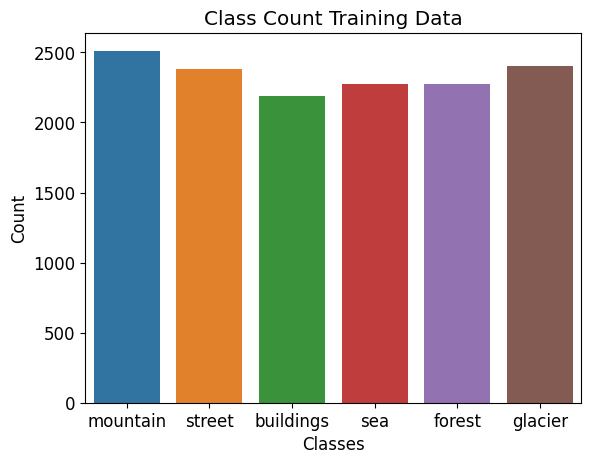

In [5]:
# Create a DataFrame for better handling
data = pd.DataFrame({'Labels': labels, 'Training Data': training_data})

# Create the bar chart
sns.barplot(x='Labels', y='Training Data', data=data)

# Add titles and labels
plt.title('Class Count Training Data')
plt.xlabel('Classes')
plt.ylabel('Count')

# Display the chart
plt.show()

### **Explanation**



- **Purpose**: Visualizes the number of testing images per class to understand the test dataset distribution.



- **Steps**:

  1. **`pd.DataFrame`**: Creates a structured DataFrame with class labels and test image counts.

  2. **`sns.barplot`**: Generates a bar chart showing the count of images for each class in the test dataset.

  3. **Labels and Titles**: Adds a title and axis labels for better readability.

  4. **`plt.show()`**: Renders the bar chart.



- **Usage**: Ensures the test dataset has sufficient and balanced images per class for reliable evaluation of the model.

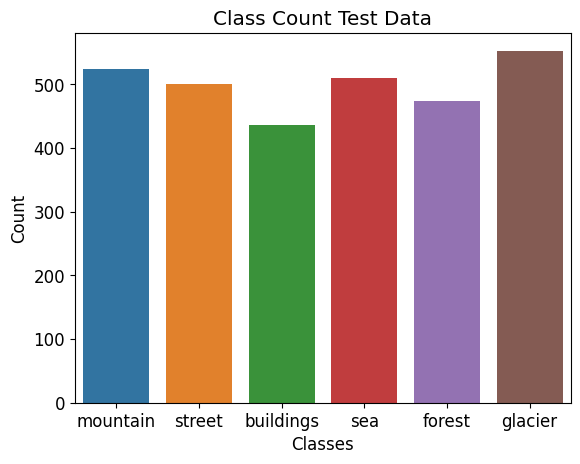

In [6]:
# Create a DataFrame for better handling
data = pd.DataFrame({'Labels': labels, 'Test Data': test_data})

# Create the bar chart
sns.barplot(x='Labels', y='Test Data', data=data)

# Add titles and labels
plt.title('Class Count Test Data')
plt.xlabel('Classes')
plt.ylabel('Count')

# Display the chart
plt.show()

### **Explanation**



- **Purpose**: Prepares training, validation, and test datasets with augmentation and preprocessing.  

- **Steps**:  

  1. **`datagen_train`**: Augments training data with rotation, shifts, zoom, flips, and rescaling; splits 80% training, 20% validation.  

  2. **`datagen_test`**: Rescales test images without augmentation.  

  3. **Generators**:

     - **`train_generator`**: Loads augmented training data, resized to `(224, 224)`.

     - **`validation_generator`**: Loads validation data from the training directory.

     - **`test_generator`**: Loads unaugmented test data, maintains order (`shuffle=False`).  

- **Usage**: Augmentation improves model generalization; validation supports tuning; test evaluates performance.

In [7]:
def custom_preprocessing(image):
    # Randomly choose a crop size
    crop_size = tf.random.uniform([], minval=100, maxval=150, dtype=tf.int32)
    cropped_image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    # Resize to target size (224x224)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    
    # Contrast adjustment
    adjusted_image = tf.image.random_contrast(resized_image, lower=0.8, upper=1.2)
    return adjusted_image

# Image augmentation for training
datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
    preprocessing_function=custom_preprocessing
)

datagen_test = ImageDataGenerator(rescale=1.0/255)

# Generators
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resizing to match pre-trained model input
    batch_size=5,
    class_mode="categorical",
    subset="training"
)

validation_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode="categorical",
    subset="validation"
)

test_generator = datagen_test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=5,
    class_mode="categorical",
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### **Explanation**



- **Purpose**: Displays a batch of images with their class labels to visually inspect the data.



- **Steps**:

  1. **`train_generator.class_indices`**: Extracts class labels from the generator.

  2. **`train_generator.__next__()`**: Fetches a batch of images and their corresponding one-hot encoded labels.

  3. **Plotting**:

     - **`plt.subplot`**: Arranges images in a grid (5x5).

     - **`np.argmax(titles[i])`**: Decodes the one-hot encoded label to the actual class name.

     - **`plt.imshow`**: Displays the image.

     - **`plt.title`**: Sets the title to show the class of each image.



- **Usage**: Helps to visually inspect a sample batch from the training set, ensuring images are correctly loaded and labeled.

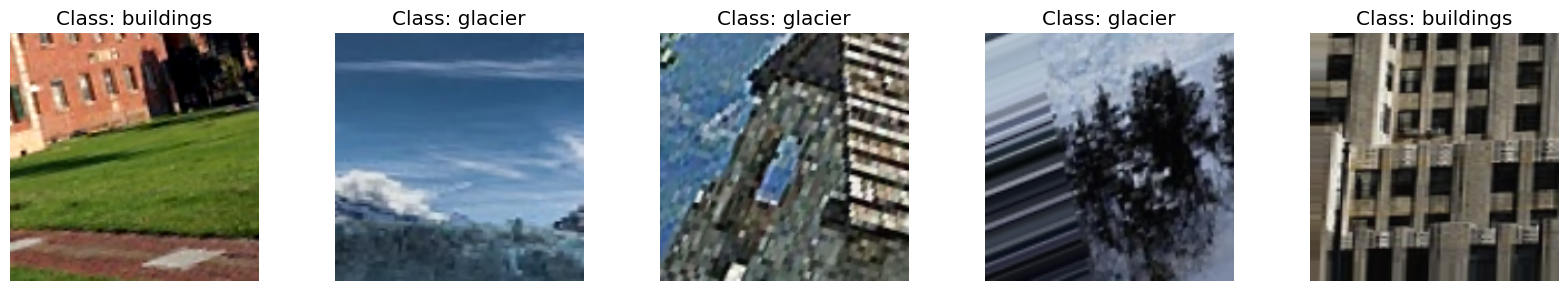

In [8]:
# Get class labels from the generator
labels = [k for k, v in train_generator.class_indices.items()]

# Get a batch of images and their labels
sample_generate = train_generator.__next__()
images = sample_generate[0]  # Image batch
titles = sample_generate[1]  # One-hot encoded labels

plt.figure(figsize=(20, 20))
for i in range(len(images)):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])  # Display the image
    plt.title(f'Class: {labels[np.argmax(titles[i])]}')  # Decode one-hot label
    plt.axis("off")
plt.show()

### **Explanation**



- **Purpose**: Defines a function to create a transfer learning model using pre-trained base models, then initializes models using different architectures.



- **Steps**:

  1. **Freezing Layers**: Freezes all layers of the pre-trained base model to retain learned features.

  2. **Custom Layers**: Adds custom layers:

     - **`GlobalAveragePooling2D`**: Reduces the spatial dimensions.

     - **`Dense(256, activation="relu")`**: Fully connected layer with ReLU activation.

     - **`BatchNormalization`**: Normalizes the output of the previous layer.

     - **`Dropout(0.2)`**: Prevents overfitting by randomly dropping 20% of units.

     - **`Dense(..., activation="softmax")`**: Output layer for multi-class classification.

  3. **Model Definition**: Combines the pre-trained base model and custom layers to define the final model.



- **Usage**: This function creates a new model by adding custom layers on top of pre-trained models (ResNet50, ResNet101, EfficientNetB0, VGG16) for transfer learning. and labeled.

In [9]:
# Function to create a transfer learning model
def create_model(base_model):
    # Freeze pre-trained model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)  
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)

    # Define model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Initialize models
resnet50_model = create_model(ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
resnet101_model = create_model(ResNet101(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
efficientnet_model = create_model(EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
vgg16_model = create_model(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))


# Display model summary for each of the models
resnet50_model.summary()
resnet101_model.summary()
efficientnet_model.summary()
vgg16_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,822 (91.99 MB)

 Trainable params: 526,598 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,185,286 (164.74 MB)

 Trainable params: 526,598 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,380,073 (16.71 MB)

 Trainable params: 329,990 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,54

 Total params: 14,848,582 (56.64 MB)

 Trainable params: 133,382 (521.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

### **Explanation**



- **Purpose**: Compiles and trains the model using the Adam optimizer and early stopping to prevent overfitting.



- **Steps**:

  1. **Compile the Model**: 

     - **`Adam(learning_rate=0.001)`**: Uses Adam optimizer with a learning rate of 0.001.

     - **`categorical_crossentropy`**: Loss function for multi-class classification.

     - **Metrics**: Tracks accuracy, precision, recall, and AUC during training.

  2. **Early Stopping**: Monitors validation loss and stops training if it doesn't improve for 10 consecutive epochs (`patience=10`), restoring the best weights.

  3. **Model Training**: Trains the model with `fit` using the training and validation generators for the specified number of epochs.



- **Usage**: Efficiently trains models with early stopping and monitoring of key performance metrics to avoid overfitting and ensure good generalization. The models (ResNet50, ResNet101, EfficientNetB0, VGG16) are trained for 50 epochs.

In [10]:
# Compile and train function
def compile_and_train(model, train_gen, val_gen, epochs=100):
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy", # Multinomial cross-entropy loss(it's for multiclass classification)
        metrics=["accuracy", "Precision", "Recall", "AUC"]
    )
    
    # Early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        batch_size=5,
        epochs=epochs,
        callbacks=[early_stopping]
    )
    return history

# Train models
resnet50_history = compile_and_train(resnet50_model, train_generator, validation_generator, epochs=50)
resnet101_history = compile_and_train(resnet101_model, train_generator, validation_generator, epochs=50)
efficientnet_history = compile_and_train(efficientnet_model, train_generator, validation_generator, epochs=50)
vgg16_history = compile_and_train(vgg16_model, train_generator, validation_generator, epochs=50)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734261487.520726      95 service.cc:145] XLA service 0x7f64ac014ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734261487.520784      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   3/2246 ━━━━━━━━━━━━━━━━━━━━ 2:19 62ms/step - AUC: 0.5962 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1778 - loss: 6.2858  

I0000 00:00:1734261493.248338      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 279s 118ms/step - AUC: 0.7114 - Precision: 0.4237 - Recall: 0.0956 - accuracy: 0.3245 - loss: 2.1036 - val_AUC: 0.5767 - val_Precision: 0.2222 - val_Recall: 0.1833 - val_accuracy: 0.2011 - val_loss: 3.1439
Epoch 2/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 213s 95ms/step - AUC: 0.7451 - Precision: 0.5668 - Recall: 0.0644 - accuracy: 0.3605 - loss: 1.6201 - val_AUC: 0.6353 - val_Precision: 0.3346 - val_Recall: 0.1573 - val_accuracy: 0.2775 - val_loss: 2.2291
Epoch 3/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 213s 94ms/step - AUC: 0.7529 - Precision: 0.5686 - Recall: 0.0600 - accuracy: 0.3681 - loss: 1.5815 - val_AUC: 0.6188 - val_Precision: 0.2229 - val_Recall: 0.1723 - val_accuracy: 0.1830 - val_loss: 2.5273
Epoch 4/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 216s 96ms/step - AUC: 0.7524 - Precision: 0.6048 - Recall: 0.0674 - accuracy: 0.3692 - loss: 1.5755 - val_AUC: 0.6769 - val_Precision: 0.2980 - val_Recall: 0.1705 - val_accuracy: 0.2272 - val_loss: 2.0295
Epoch 5/50
2246/2246 ━

### **Explanation**



- **Purpose**: Saves the trained models to disk for future use, such as for inference or further fine-tuning.



- **Steps**:

  1. **`model.save()`**: Saves the trained model in HDF5 format (`.h5`), which contains the model architecture, weights, and optimizer state.

  2. **Models Saved**: Each model (ResNet50, ResNet101, EfficientNetB0, VGG16) is saved with a unique filename (`resnet50_model.h5`, etc.).



- **Usage**: Ensures models are saved after training so they can be easily loaded for future predictions, deployment, or continued training without retraining from scratch.

In [11]:
# Save each trained model to a file
resnet50_model.save('resnet50_model.h5')
resnet101_model.save('resnet101_model.h5')
efficientnet_model.save('efficientnet_model.h5')
vgg16_model.save('vgg16_model.h5')

### **Explanation**

- **Purpose**: Evaluates each model's performance on the test dataset and visualizes classification results using key metrics and a confusion matrix.

- **Steps**:
  1. **`model.predict(test_gen)`**: Generates predicted probabilities for the test data.
  2. **`np.argmax(predictions, axis=1)`**: Converts predicted probabilities into discrete class labels.
  3. **`test_gen.classes`**: Retrieves the ground truth labels of the test set.
  4. **`classification_report(y_true, y_pred)`**: Prints metrics like precision, recall, F1-score, and support for each class.
  5. **`confusion_matrix(y_true, y_pred)`**: Computes the confusion matrix to show true vs. predicted labels.
  6. **`seaborn.heatmap`**: Plots the confusion matrix for visual interpretation of classification accuracy and errors.

- **Usage**: Assesses trained models (ResNet50, ResNet101, EfficientNetB0, VGG16) on the test dataset, providing insights into their performance, strengths, and weaknesses across classes. This aids in identifying areas for improvement and comparing models.

600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

   buildings       0.36      0.61      0.45       437
      forest       0.86      0.72      0.79       474
     glacier       0.33      0.56      0.42       553
    mountain       0.00      0.00      0.00       525
         sea       0.40      0.74      0.52       510
      street       1.00      0.00      0.01       501

    accuracy                           0.43      3000
   macro avg       0.49      0.44      0.36      3000
weighted avg       0.49      0.43      0.36      3000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


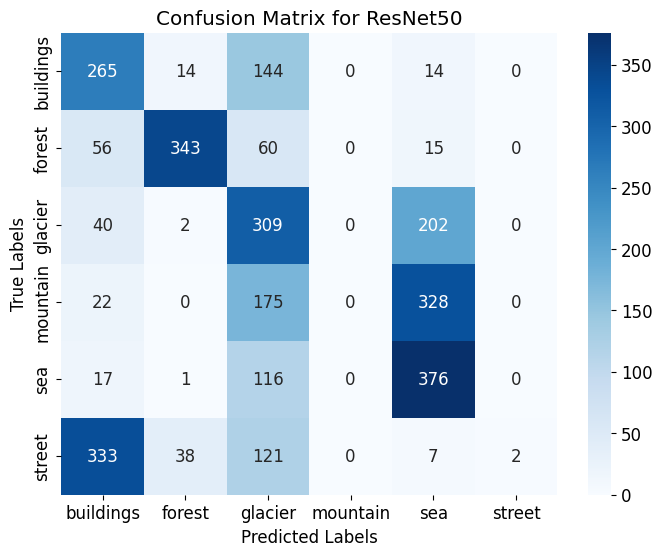

600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step
Classification Report for ResNet101:
              precision    recall  f1-score   support

   buildings       0.40      0.75      0.52       437
      forest       0.71      0.69      0.70       474
     glacier       0.37      0.69      0.48       553
    mountain       0.44      0.41      0.43       525
         sea       0.73      0.02      0.04       510
      street       0.64      0.22      0.32       501

    accuracy                           0.46      3000
   macro avg       0.55      0.46      0.41      3000
weighted avg       0.55      0.46      0.41      3000



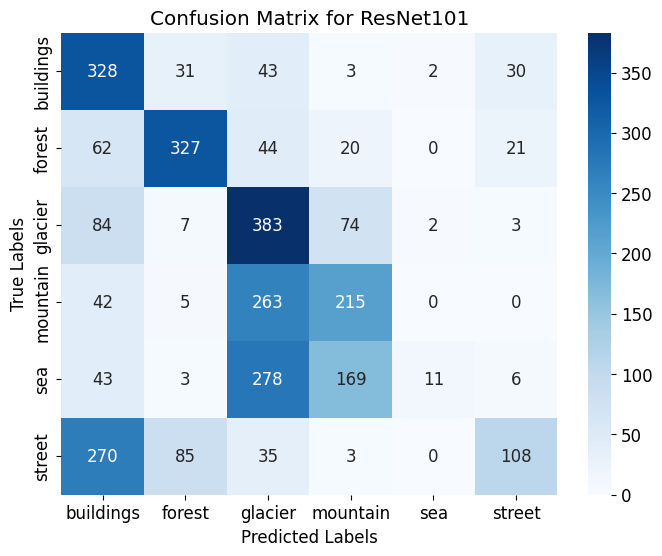

600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.17      1.00      0.30       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


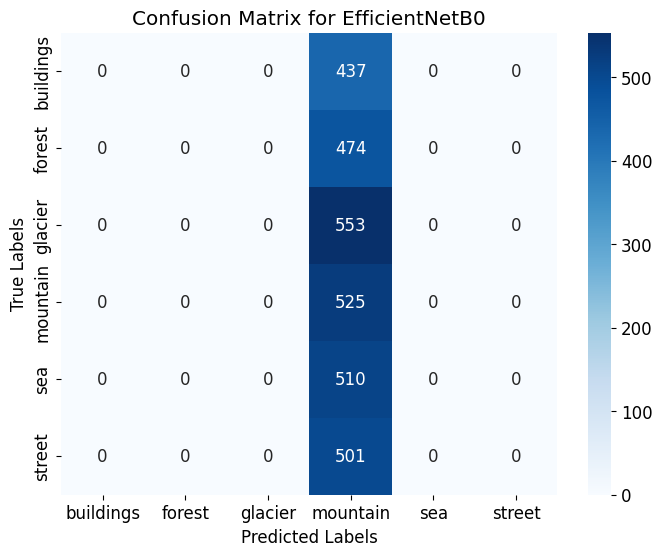

600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

   buildings       0.69      0.90      0.78       437
      forest       0.96      0.95      0.95       474
     glacier       0.72      0.81      0.76       553
    mountain       0.84      0.60      0.70       525
         sea       0.78      0.87      0.82       510
      street       0.83      0.65      0.73       501

    accuracy                           0.79      3000
   macro avg       0.80      0.80      0.79      3000
weighted avg       0.80      0.79      0.79      3000



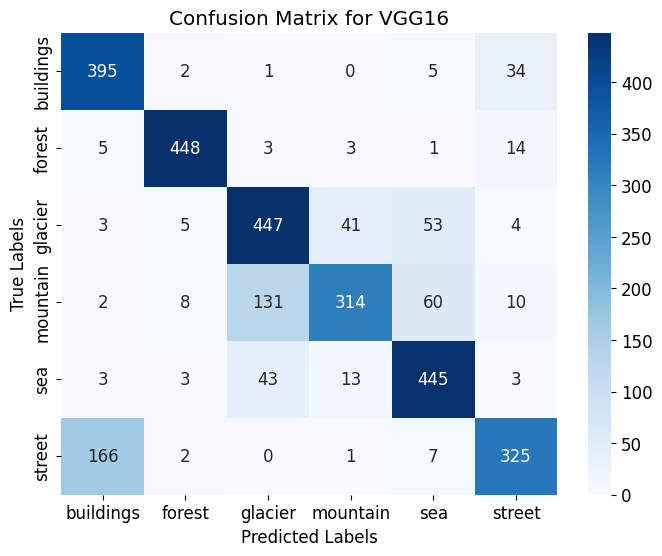

In [12]:
def evaluate_model_with_plot(model, test_gen, model_name):
    test_gen.reset()
    predictions = model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = list(test_gen.class_indices.keys())
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Evaluate each model with plotting
evaluate_model_with_plot(resnet50_model, test_generator, "ResNet50")
evaluate_model_with_plot(resnet101_model, test_generator, "ResNet101")
evaluate_model_with_plot(efficientnet_model, test_generator, "EfficientNetB0")
evaluate_model_with_plot(vgg16_model, test_generator, "VGG16")

### **Explanation**

- **Purpose**: Visualize training and validation metrics (loss, accuracy, AUC, precision, recall) over epochs for each model.

- **Steps**:
  1. **Loss**: Plots training (`history.history["loss"]`) and validation loss (`history.history["val_loss"]`).
  2. **Accuracy**: Plots training (`history.history["accuracy"]`) and validation accuracy (`history.history["val_accuracy"]`).
  3. **AUC**: Plots training (`history.history["AUC"]`) and validation AUC (`history.history["val_AUC"]`).
  4. **Precision**: Plots training (`history.history["Precision"]`) and validation precision (`history.history["val_Precision"]`).
  5. **Recall**: Plots training (`history.history["Recall"]`) and validation recall (`history.history["val_Recall`).
  6. **Display**: `plt.tight_layout()` adjusts spacing, `plt.show()` displays plots.

- **Usage**: Helps evaluate training performance and diagnose overfitting, underfitting, and model effectiveness for ResNet50, ResNet101, EfficientNetB0, and VGG16.entNetB0, VGG16).

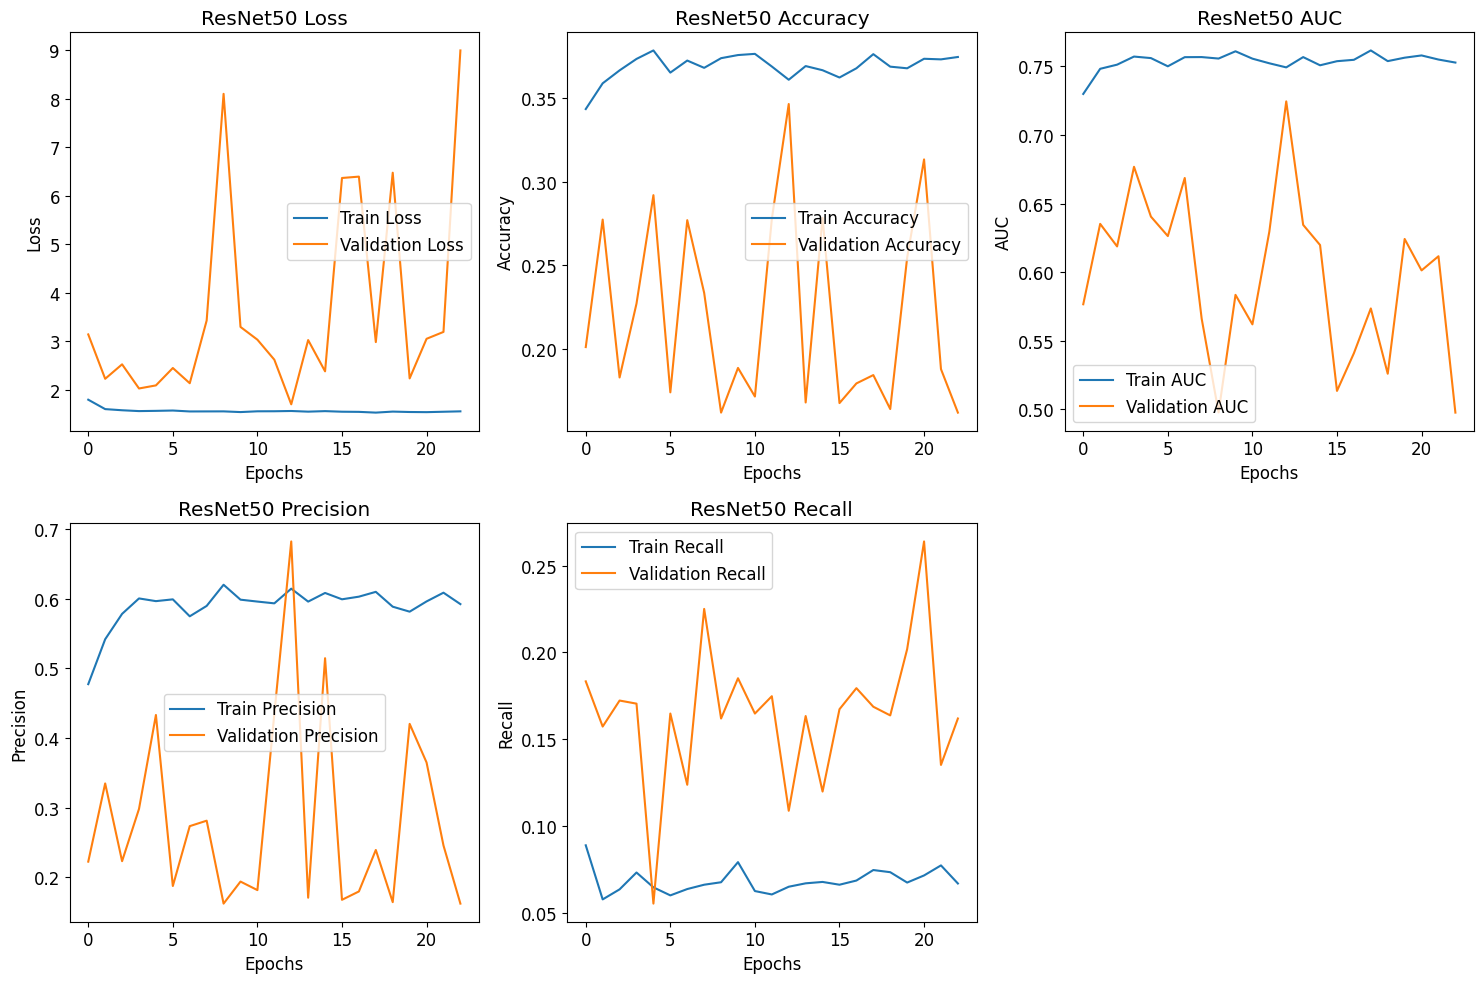

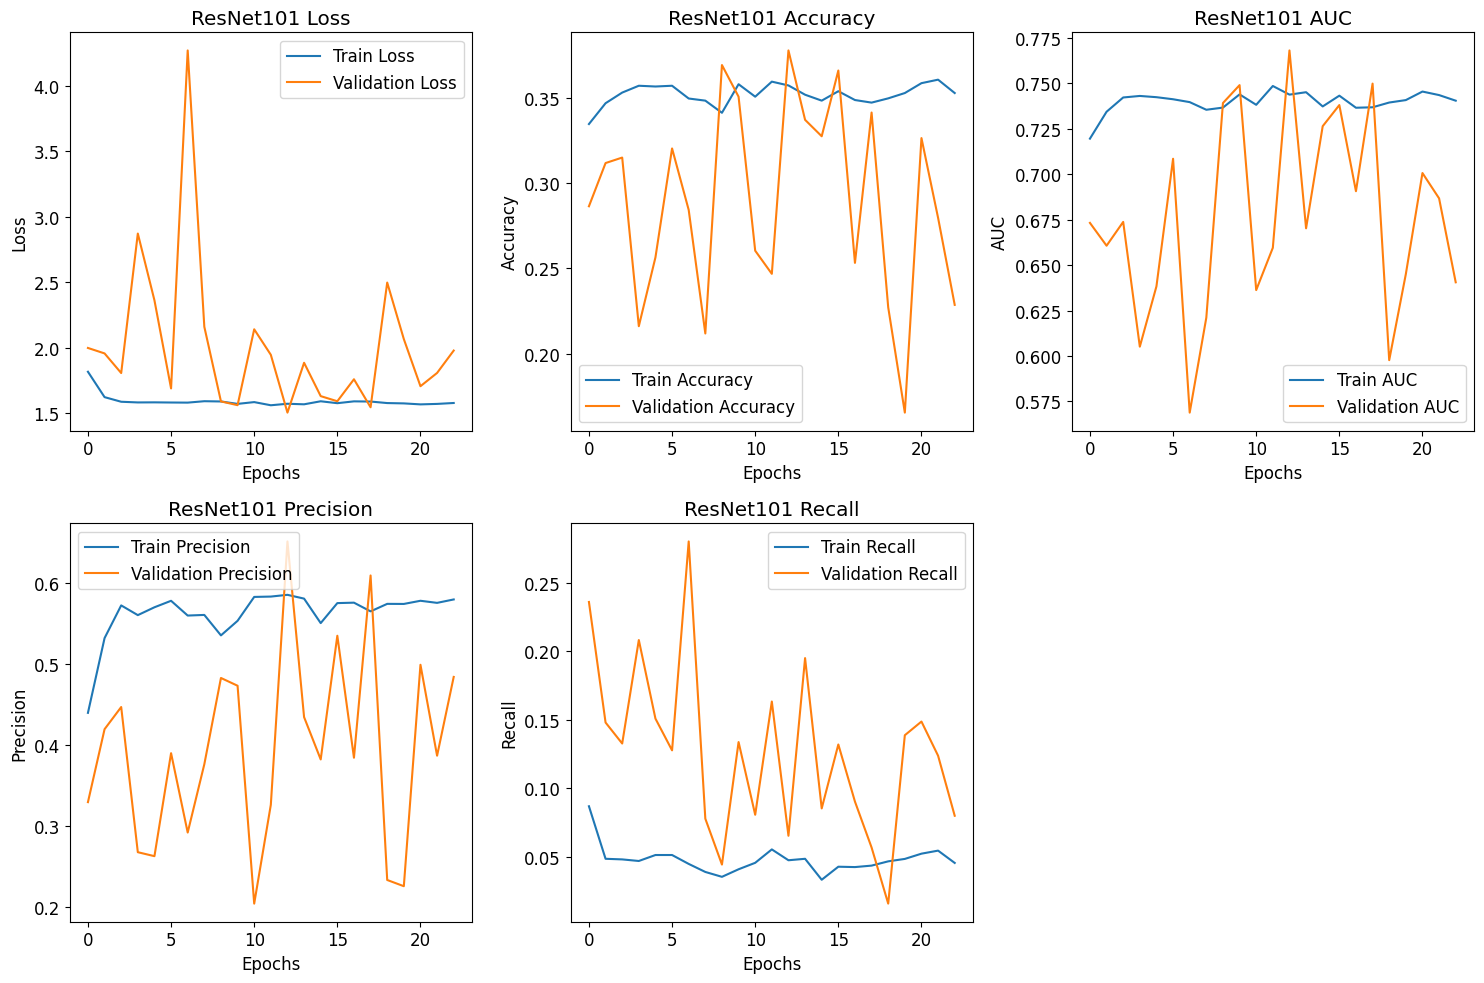

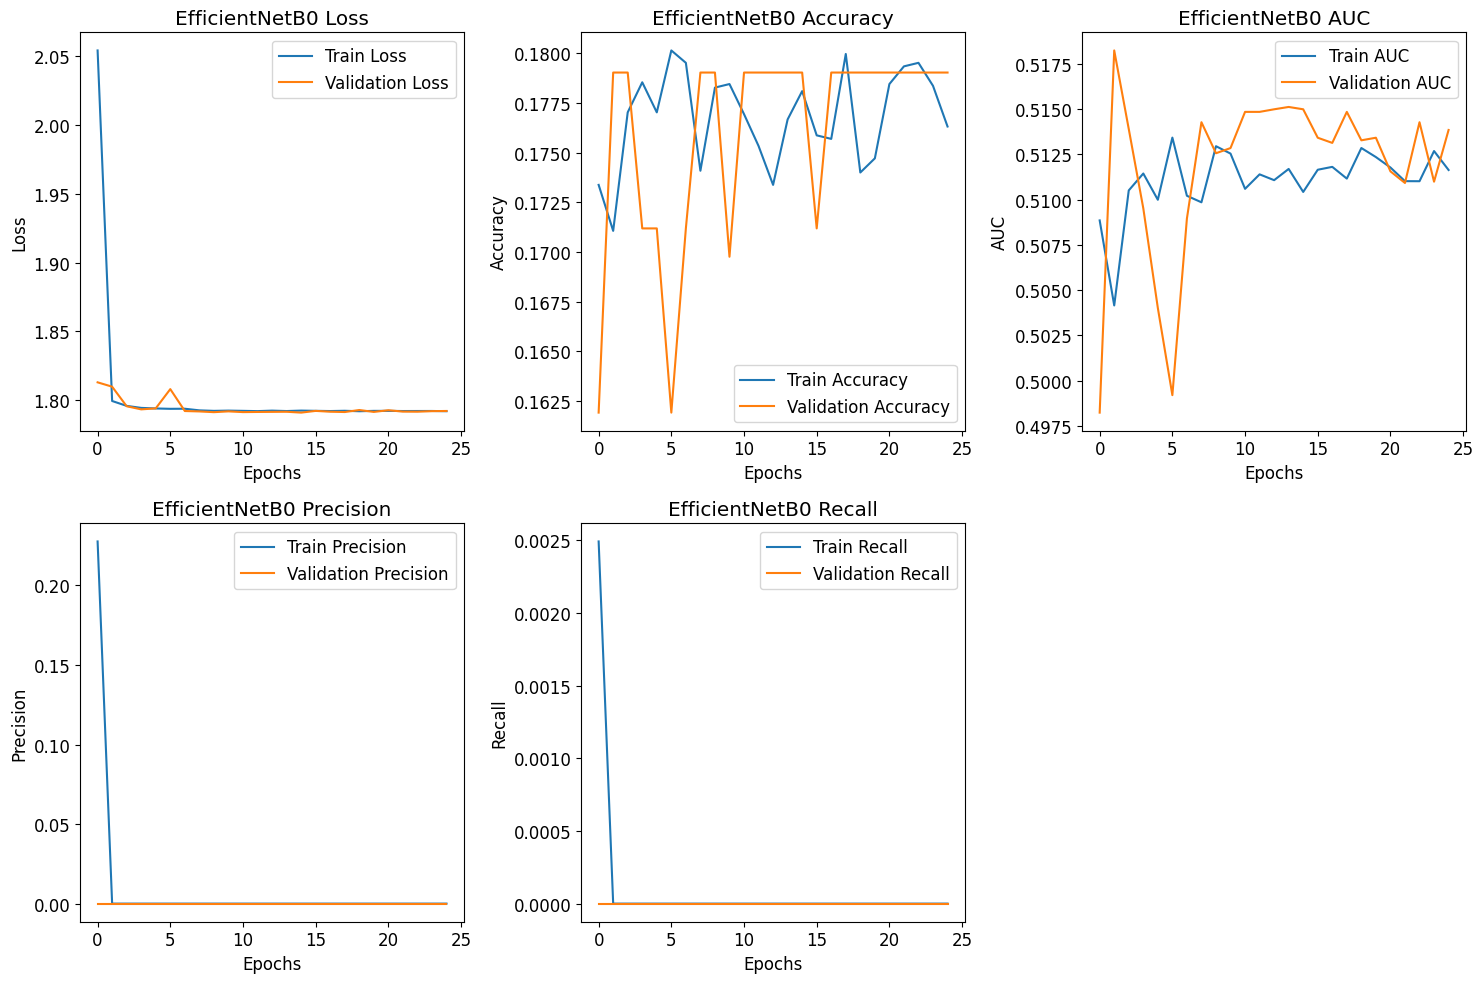

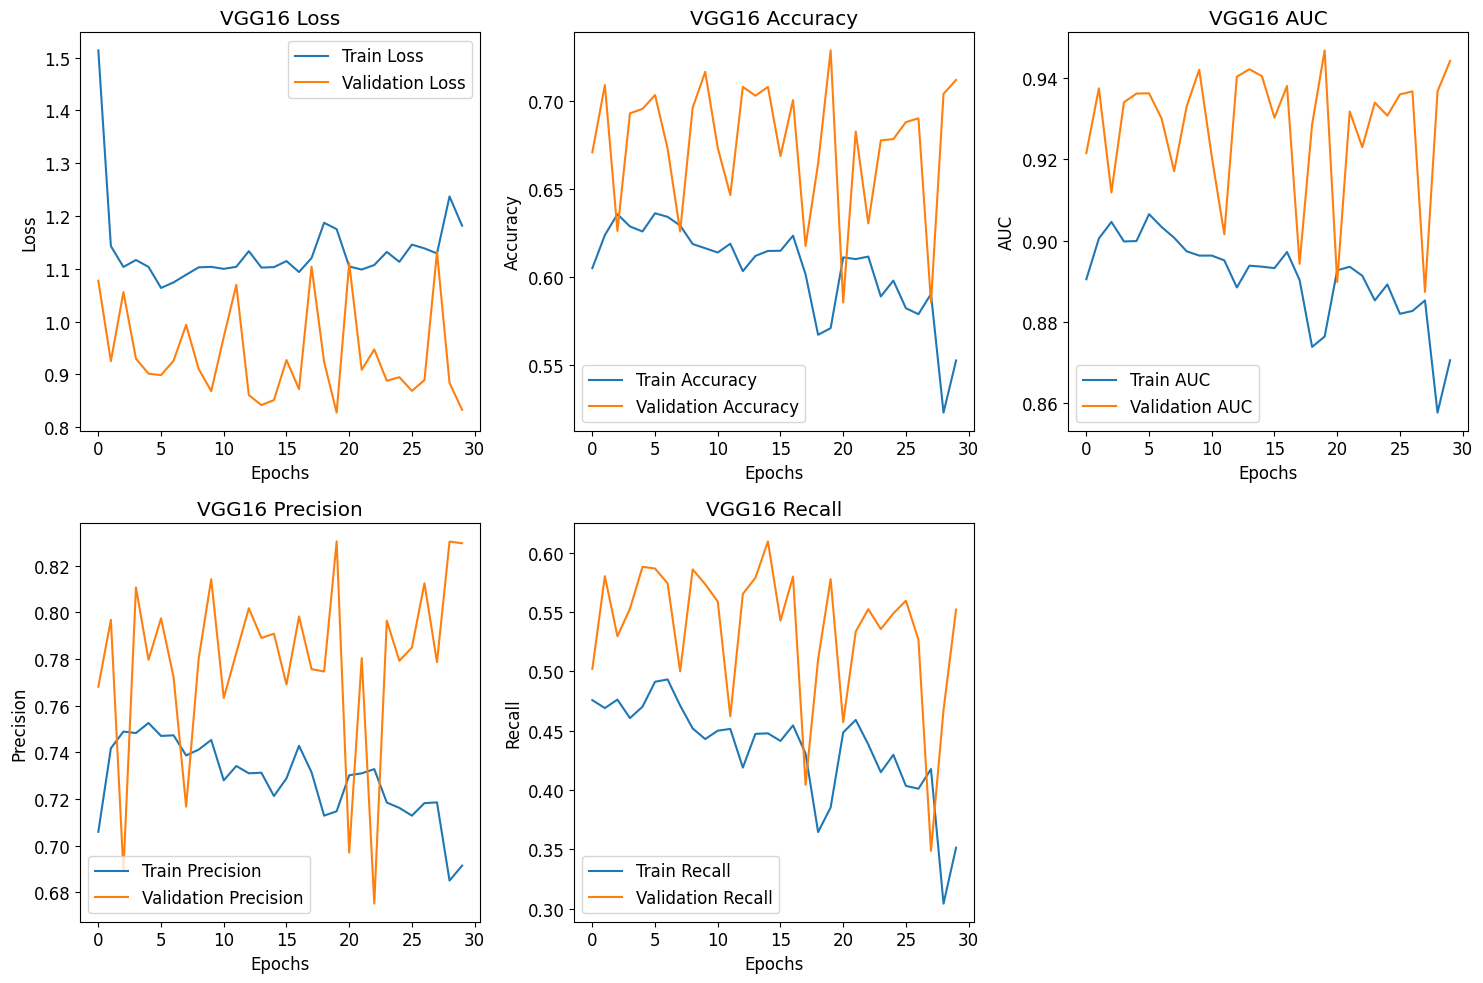

In [13]:
# Function to plot the metrics
def plot_metrics(history, model_name):
    plt.figure(figsize=(15, 10))

    # Plot Loss
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot AUC
    plt.subplot(2, 3, 3)
    plt.plot(history.history['AUC'], label="Train AUC")
    plt.plot(history.history['val_AUC'], label="Validation AUC")
    plt.title(f"{model_name} AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()

    # Plot Precision
    plt.subplot(2, 3, 4)
    plt.plot(history.history['Precision'], label="Train Precision")
    plt.plot(history.history['val_Precision'], label="Validation Precision")
    plt.title(f"{model_name} Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    # Plot Recall
    plt.subplot(2, 3, 5)
    plt.plot(history.history['Recall'], label="Train Recall")
    plt.plot(history.history['val_Recall'], label="Validation Recall")
    plt.title(f"{model_name} Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot for each model
plot_metrics(resnet50_history, "ResNet50")
plot_metrics(resnet101_history, "ResNet101")
plot_metrics(efficientnet_history, "EfficientNetB0")
plot_metrics(vgg16_history, "VGG16")


### **Conclusion**



- **VGG16** outperforms other models (ResNet50, ResNet101, EfficientNetB0) in terms of metrics, making it the most effective for this task.

- Its simple, deep architecture generalizes well, especially with smaller datasets.

- **Recommendation**: VGG16 is the best choice for this classification problem, offering the best balance of performance and efficiency.